  SN name  Redshift  Distance modulus  Distance modulus error  P low mass
0  1993ah  0.028488         35.346583                0.223906    0.128419
1  1993ag  0.050043         36.682368                0.166829    0.128419
2   1993o  0.052926         36.817691                0.155756    0.128419
3   1993b  0.070086         37.446737                0.158467    0.128419
4  1992bs  0.062668         37.483409                0.156099    0.128419
Number of supernovae with z < 0.5: 412 (71.0% of total)


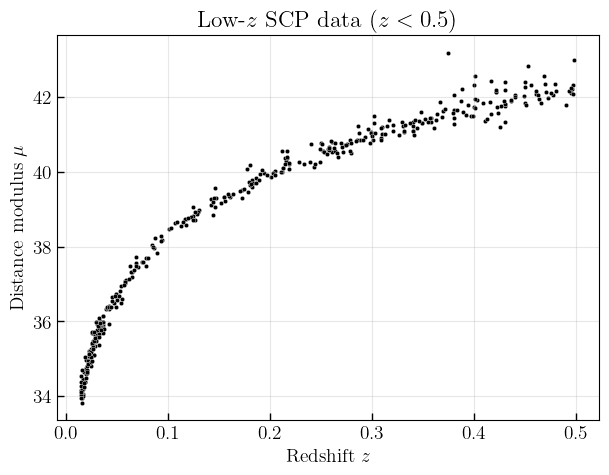

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emcee
import corner

from scipy import integrate, optimize, special
from scipy.optimize import minimize

# -------------------------------------------------
# Plot style
# -------------------------------------------------

saved_figs = []

plt.rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'

# -------------------------------------------------
# Load SCP Union 2.1 data
# -------------------------------------------------
datafile = open('./data/SCPUnion2.1_mu_vs_z.txt', 'r')
SCP_data = pd.read_table(
    datafile,
    comment='#',
    names=['SN name', 'Redshift', 'Distance modulus',
           'Distance modulus error', 'P low mass']
)

print(SCP_data.head())

# All-z data arrays (used in Task 2 and for extrapolations)
z_all      = SCP_data['Redshift'].values
mu_all     = SCP_data['Distance modulus'].values
mu_err_all = SCP_data['Distance modulus error'].values

# Low-z subset (z < 0.5) for Task 1
df_lowz    = SCP_data[SCP_data['Redshift'] < 0.5].copy()
z_data     = df_lowz['Redshift'].values
mu_data    = df_lowz['Distance modulus'].values
mu_err_data= df_lowz['Distance modulus error'].values

print(f"Number of supernovae with z < 0.5: {len(df_lowz)} "
      f"({len(df_lowz)/len(SCP_data)*100:.1f}% of total)")

# Quick scatter plot of low-z data
plt.figure(figsize=(7,5))
sns.scatterplot(x=z_data, y=mu_data, color='black', s=10)
plt.xlabel('Redshift $z$')
plt.ylabel(r'Distance modulus $\mu$')
plt.title('Low-$z$ SCP data ($z<0.5$)')
plt.grid(alpha=0.3)
plt.savefig("1.png", dpi=300, bbox_inches="tight")
plt.show()


In [2]:
# Speed of light
c = 299792.458  # km/s

def distance_modulus_smallz(z, H0, q0):
    """
    Small-z luminosity distance and distance modulus:

    d_L = (c/H0) [z + 0.5 (1 - q0) z^2]
    μ   = 5 log10(d_L/Mpc) + 25
    """
    z = np.asarray(z)
    dL = (c / H0) * (z + 0.5 * (1.0 - q0) * z**2)
    mu = 5.0 * np.log10(dL + 1e-10) + 25.0
    return mu


def log_inverse_gamma(x, alpha, beta):
    """
    log p(x | α, β) for inverse-gamma with parameters (α, β).
    Only valid for x>0.
    """
    if x <= 0:
        return -np.inf
    return (alpha * np.log(beta) - special.gammaln(alpha)
            - (alpha + 1) * np.log(x) - beta / x)


def log_prior_smallz(params):
    """
    Priors for [H0, q0, sigma2]:
      - H0 ~ Uniform(50, 100)
      - q0 ~ Uniform(-2, 2)
      - sigma2 ~ InvGamma(α=2, β=0.1)  (intrinsic scatter variance)
    """
    H0, q0, sigma2 = params

    if not (50.0 < H0 < 100.0):
        return -np.inf
    if not (-2.0 < q0 < 2.0):
        return -np.inf

    alpha = 2.0
    beta  = 0.1
    lp_sigma2 = log_inverse_gamma(sigma2, alpha, beta)
    return lp_sigma2


def log_likelihood_smallz(params, z, mu_obs, mu_err):
    """
    Gaussian likelihood with measurement errors and intrinsic scatter σ².
    """
    H0, q0, sigma2 = params
    if sigma2 <= 0:
        return -np.inf

    mu_model = distance_modulus_smallz(z, H0, q0)
    total_var = mu_err**2 + sigma2  # measurement + intrinsic

    logL = -0.5 * np.sum(
        (mu_obs - mu_model)**2 / total_var
        + np.log(2 * np.pi * total_var)
    )
    return logL


def log_posterior_smallz(params, z, mu_obs, mu_err):
    lp = log_prior_smallz(params)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_smallz(params, z, mu_obs, mu_err)
    return lp + ll


In [3]:
initial_guess = np.array([70.0, -0.5, 0.04])

print("Finding MAP estimate for (H0, q0, sigma2)...")
res_map = minimize(
    lambda p: -log_posterior_smallz(p, z_data, mu_data, mu_err_data),
    initial_guess,
    method='Nelder-Mead'
)

if not res_map.success:
    print("WARNING: MAP optimisation did not converge, using initial guess.")
    map_estimate = initial_guess
else:
    map_estimate = res_map.x

H0_map, q0_map, sigma2_map = map_estimate
print(f"MAP: H0 = {H0_map:.2f} km/s/Mpc,  q0 = {q0_map:.3f},  sigma^2 = {sigma2_map:.3f}")


Finding MAP estimate for (H0, q0, sigma2)...
MAP: H0 = 69.71 km/s/Mpc,  q0 = -0.415,  sigma^2 = 0.007


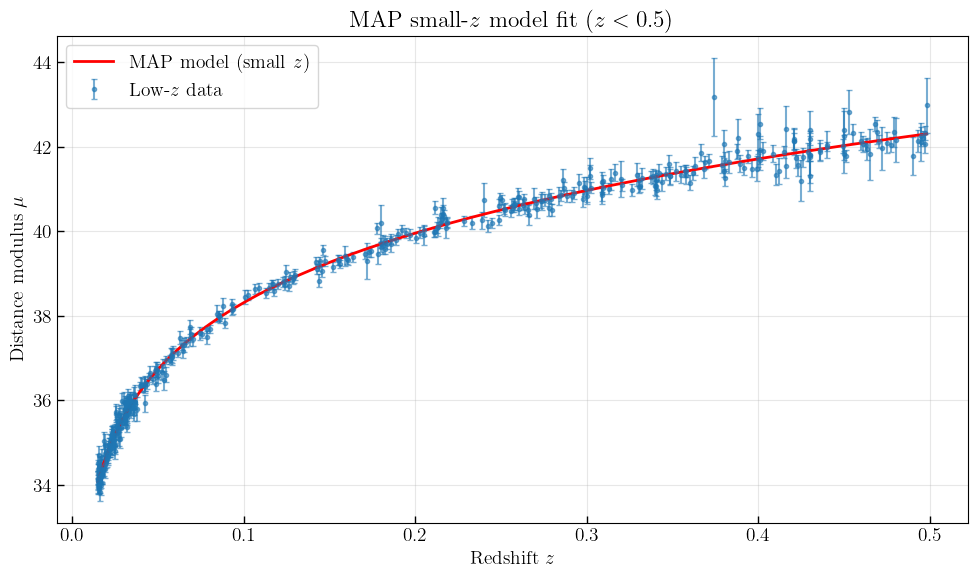

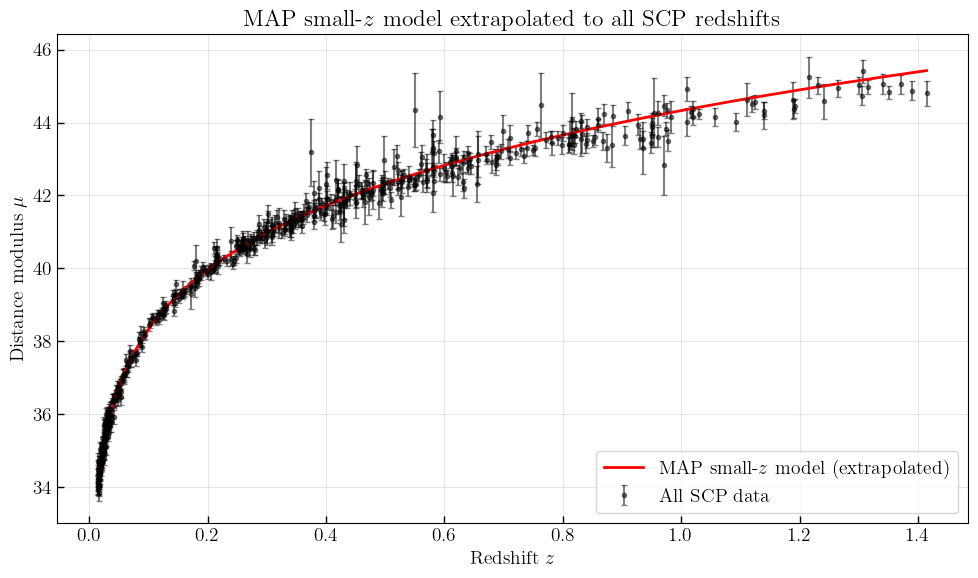

In [4]:
plt.figure(figsize=(10, 6))

# use the same z values as the low-z data (sorted), so no tail at z≈0
df_lowz = SCP_data[SCP_data['Redshift'] < 0.5].copy()
z_plot_low = np.sort(df_lowz['Redshift'].values)
mu_plot_low = distance_modulus_smallz(z_plot_low, H0_map, q0_map)

plt.errorbar(
    z_data, mu_data, yerr=mu_err_data,
    fmt='o', alpha=0.6, label='Low-$z$ data', markersize=3, capsize=2
)
plt.plot(z_plot_low, mu_plot_low, 'r-', linewidth=2,
         label='MAP model (small $z$)')

plt.xlabel('Redshift $z$')
plt.ylabel(r'Distance modulus $\mu$')
plt.title(r'MAP small-$z$ model fit ($z<0.5$)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("2.png", dpi=300, bbox_inches="tight")
plt.show()

# Extrapolation across full z-range of SCP data
plt.figure(figsize=(10, 6))
z_plot_all = np.sort(SCP_data['Redshift'].values)
mu_plot_all = distance_modulus_smallz(z_plot_all, H0_map, q0_map)

plt.errorbar(
    z_all, mu_all, yerr=mu_err_all,
    fmt='o', alpha=0.5, markersize=3, capsize=2,
    color='black', label='All SCP data'
)
plt.plot(z_plot_all, mu_plot_all, 'r-', lw=2,
         label='MAP small-$z$ model (extrapolated)')
plt.xlabel('Redshift $z$')
plt.ylabel(r'Distance modulus $\mu$')
plt.title(r'MAP small-$z$ model extrapolated to all SCP redshifts')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("3.png", dpi=300, bbox_inches="tight")
plt.show()


In [5]:
# MCMC setup
nwalkers = 32
ndim     = 3  # [H0, q0, sigma2]
nsteps   = 2000
burnin   = 500

# initialise walkers around MAP
initial_pos = map_estimate + 1e-4 * np.random.randn(nwalkers, ndim)

sampler_smallz = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_smallz,
    args=(z_data, mu_data, mu_err_data)
)

print("Running MCMC for (H0, q0, sigma2)...")
sampler_smallz.run_mcmc(initial_pos, nsteps, progress=True)

# Flatten chain (discard burn-in)
samples_smallz = sampler_smallz.chain[:, burnin:, :].reshape(-1, ndim)
H0_samples    = samples_smallz[:, 0]
q0_samples    = samples_smallz[:, 1]
sigma2_samples= samples_smallz[:, 2]

print(f"MCMC complete: {samples_smallz.shape[0]} posterior samples")


Running MCMC for (H0, q0, sigma2)...


100%|███████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 380.54it/s]

MCMC complete: 48000 posterior samples


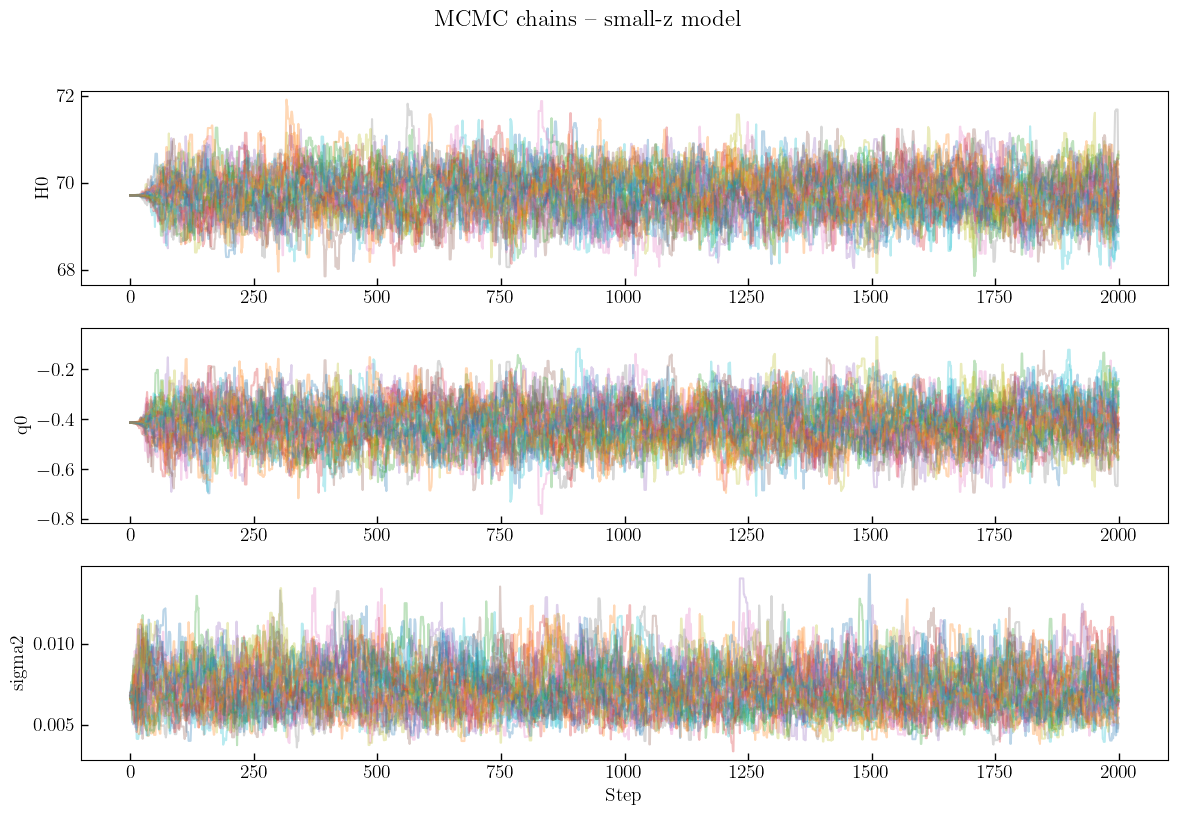

TASK 1 RESULTS
H0 = 69.7 +0.5 / -0.5 km/s/Mpc
q0 = -0.419 +0.081 / -0.080
Intrinsic scatter variance sigma^2 ≈ 0.007
P(q0 < 0) = 100.0%


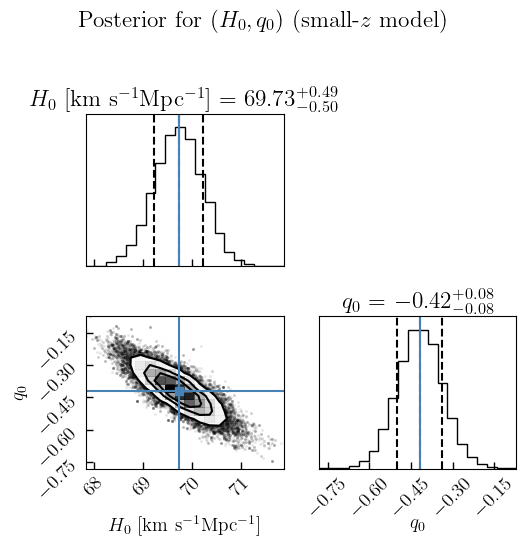

In [6]:
# Trace plots
plt.figure(figsize=(12, 8))
labels = ['H0', 'q0', 'sigma2']
for i in range(ndim):
    plt.subplot(ndim, 1, i+1)
    plt.plot(sampler_smallz.chain[:, :, i].T, alpha=0.3)
    plt.ylabel(labels[i])
plt.xlabel('Step')
plt.suptitle('MCMC chains – small-z model', y=1.02)
plt.tight_layout()
plt.savefig("4.png", dpi=300, bbox_inches="tight")
plt.show()

# Marginal summaries
H0_med  = np.median(H0_samples)
H0_low, H0_high = np.percentile(H0_samples, [16, 84])

q0_med  = np.median(q0_samples)
q0_low, q0_high = np.percentile(q0_samples, [16, 84])

sigma2_med = np.median(sigma2_samples)

print("TASK 1 RESULTS")
print(f"H0 = {H0_med:.1f} +{H0_high-H0_med:.1f} / -{H0_med-H0_low:.1f} km/s/Mpc")
print(f"q0 = {q0_med:.3f} +{q0_high-q0_med:.3f} / -{q0_med-q0_low:.3f}")
print(f"Intrinsic scatter variance sigma^2 ≈ {sigma2_med:.3f}")

prob_accel = np.mean(q0_samples < 0.0)
print(f"P(q0 < 0) = {prob_accel*100:.1f}%")

# Corner plot for H0, q0
corner.corner(
    samples_smallz[:, :2],
    labels=[r'$H_0$ [km s$^{-1}$Mpc$^{-1}$]', r'$q_0$'],
    truths=[H0_med, q0_med],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True
)
plt.suptitle('Posterior for $(H_0, q_0)$ (small-$z$ model)', y=1.02)
plt.tight_layout()
plt.savefig("5.png", dpi=300, bbox_inches="tight")
plt.show()


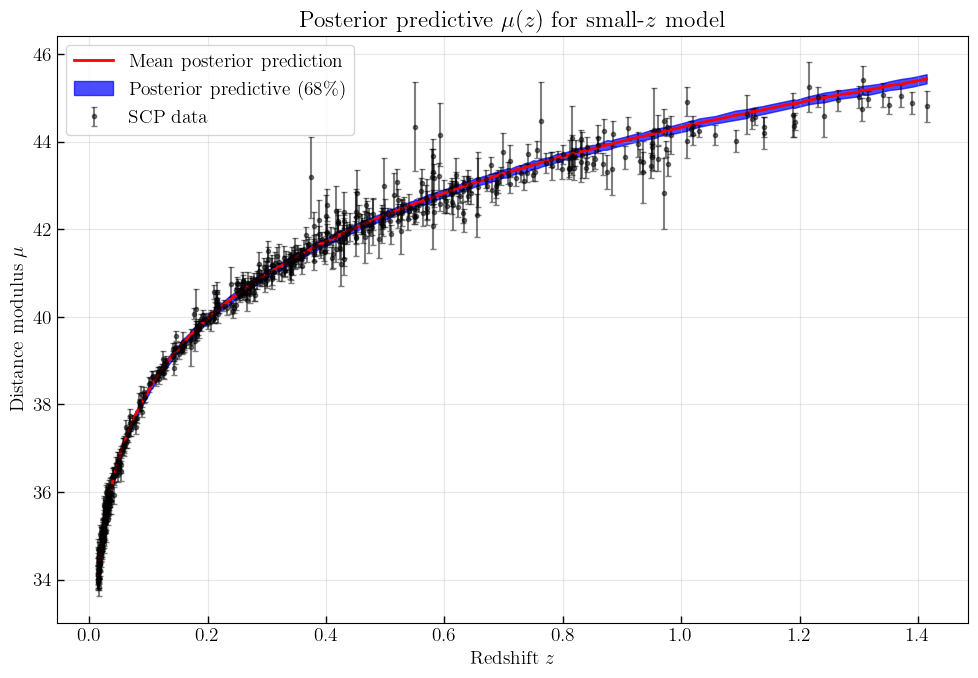

In [7]:
# Posterior predictive over full SCP z-range
z_grid = z_plot_all
#z_grid = np.linspace(0.0, np.max(z_all)*1.05, 300)

n_draws = 200
rng = np.random.default_rng(42)
idx = rng.choice(samples_smallz.shape[0], size=n_draws, replace=False)

mu_pp = np.empty((n_draws, z_grid.size))

for i, j in enumerate(idx):
    H0_i, q0_i, sigma2_i = samples_smallz[j]
    mu_mean_i = distance_modulus_smallz(z_grid, H0_i, q0_i)
    sigma_i = np.sqrt(max(sigma2_i, 1e-10))
    # include intrinsic scatter in predictive
    mu_pp[i] = mu_mean_i + rng.normal(0.0, sigma_i, size=z_grid.shape)

mu_pp_med  = np.mean(mu_pp, axis=0)
mu_pp_low, mu_pp_high = np.percentile(mu_pp, [16, 84], axis=0)

plt.figure(figsize=(10, 7))
plt.errorbar(
    z_all, mu_all, yerr=mu_err_all,
    fmt='o', ms=3, alpha=0.5, capsize=2,
    color='black', label='SCP data'
)
plt.plot(z_grid, mu_pp_med, 'r-', lw=2, label='Mean posterior prediction')
plt.fill_between(
    z_grid, mu_pp_low, mu_pp_high,
    color='blue', alpha=0.7,
    label='Posterior predictive (68\%)'
)
plt.xlabel('Redshift $z$')
plt.ylabel(r'Distance modulus $\mu$')
plt.title(r'Posterior predictive $\mu(z)$ for small-$z$ model')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("6.png", dpi=300, bbox_inches="tight")
plt.show()


TASK 2

In [8]:
H0_fixed = 70.0  # km s^-1 Mpc^-1

def E_LCDM(z, Omega_m0):
    """Dimensionless H(z)/H0 for flat ΛCDM."""
    Omega_lambda0 = 1.0 - Omega_m0
    return np.sqrt(Omega_m0 * (1 + z)**3 + Omega_lambda0)

def E_wCDM(z, Omega_m0, w):
    """Dimensionless H(z)/H0 for flat wCDM."""
    Omega_de0 = 1.0 - Omega_m0
    return np.sqrt(
        Omega_m0 * (1 + z)**3
        + Omega_de0 * (1 + z)**(3 * (1 + w))
    )

def dL_Mpc(z, E_func, params):
    """
    Luminosity distance:

    d_L(z) = (c/H0_fixed) (1+z) ∫_0^z dz'/E(z')
    """
    z = np.atleast_1d(z)

    def integrand(zp, *pars):
        return 1.0 / E_func(zp, *pars)

    dL = np.zeros_like(z, dtype=float)
    for i, zi in enumerate(z):
        integral, _ = integrate.quad(integrand, 0.0, zi, args=params)
        dL[i] = (c / H0_fixed) * (1.0 + zi) * integral
    return dL

def distance_modulus_cosmo(z, E_func, params):
    dL = dL_Mpc(z, E_func, params)
    return 5.0 * np.log10(dL + 1e-10) + 25.0


In [9]:
def loglike_LCDM(params, z, mu_obs, mu_err):
    """
    params: [Omega_m0]
    """
    Omega_m0 = params[0]
    if not (0.0 <= Omega_m0 <= 1.0):
        return -np.inf

    mu_model = distance_modulus_cosmo(z, E_LCDM, (Omega_m0,))
    resid = mu_obs - mu_model

    chi2 = np.sum((resid / mu_err)**2)
    logL = -0.5 * (chi2 + np.sum(np.log(2 * np.pi * mu_err**2)))
    return logL


def loglike_wCDM(params, z, mu_obs, mu_err):
    """
    params: [Omega_m0, w]
    Prior: 0 <= Omega_m0 <= 1,   -2 <= w <= 0
    """
    Omega_m0, w = params
    if not (0.0 <= Omega_m0 <= 1.0) or not (-2.0 <= w <= 0.0):
        return -np.inf

    mu_model = distance_modulus_cosmo(z, E_wCDM, (Omega_m0, w))
    resid = mu_obs - mu_model

    chi2 = np.sum((resid / mu_err)**2)
    logL = -0.5 * (chi2 + np.sum(np.log(2 * np.pi * mu_err**2)))
    return logL


In [10]:
N = len(z_all)

# --- ΛCDM: 1 parameter Ω_m0 ---
k_lcdm = 1
x0_lcdm = np.array([0.3])
bounds_lcdm = [(0.0, 1.0)]

res_lcdm = minimize(
    lambda p: -loglike_LCDM(p, z_all, mu_all, mu_err_all),
    x0_lcdm,
    bounds=bounds_lcdm,
    method='L-BFGS-B'
)

Omega_m0_mle_lcdm = res_lcdm.x[0]
logL_lcdm = -res_lcdm.fun

AIC_lcdm = 2 * k_lcdm - 2 * logL_lcdm
BIC_lcdm = k_lcdm * np.log(N) - 2 * logL_lcdm

print("ΛCDM fit:")
print(f"  Ω_m0 = {Omega_m0_mle_lcdm:.4f}")
print(f"  logL = {logL_lcdm:.2f},  AIC = {AIC_lcdm:.2f},  BIC = {BIC_lcdm:.2f}")


# --- wCDM: 2 parameters (Ω_m0, w) ---
k_wcdm = 2
x0_wcdm = np.array([0.3, -1.0])
bounds_wcdm = [(0.0, 1.0), (-2.0, 0.0)]

res_wcdm = minimize(
    lambda p: -loglike_wCDM(p, z_all, mu_all, mu_err_all),
    x0_wcdm,
    bounds=bounds_wcdm,
    method='L-BFGS-B'
)

Omega_m0_mle_wcdm, w_mle = res_wcdm.x
logL_wcdm = -res_wcdm.fun

AIC_wcdm = 2 * k_wcdm - 2 * logL_wcdm
BIC_wcdm = k_wcdm * np.log(N) - 2 * logL_wcdm

print("\nwCDM fit:")
print(f"  Ω_m0 = {Omega_m0_mle_wcdm:.4f},  w = {w_mle:.4f}")
print(f"  logL = {logL_wcdm:.2f},  AIC = {AIC_wcdm:.2f},  BIC = {BIC_wcdm:.2f}")

print("\nModel comparison (wCDM - ΛCDM):")
print(f"  ΔAIC = {AIC_wcdm - AIC_lcdm:.2f}  (positive → ΛCDM preferred)")
print(f"  ΔBIC = {BIC_wcdm - BIC_lcdm:.2f}  (positive → ΛCDM preferred)")


ΛCDM fit:
  Ω_m0 = 0.2777
  logL = 118.74,  AIC = -235.48,  BIC = -231.12

wCDM fit:
  Ω_m0 = 0.2796,  w = -1.0045
  logL = 118.74,  AIC = -233.48,  BIC = -224.76

Model comparison (wCDM - ΛCDM):
  ΔAIC = 2.00  (positive → ΛCDM preferred)
  ΔBIC = 6.36  (positive → ΛCDM preferred)


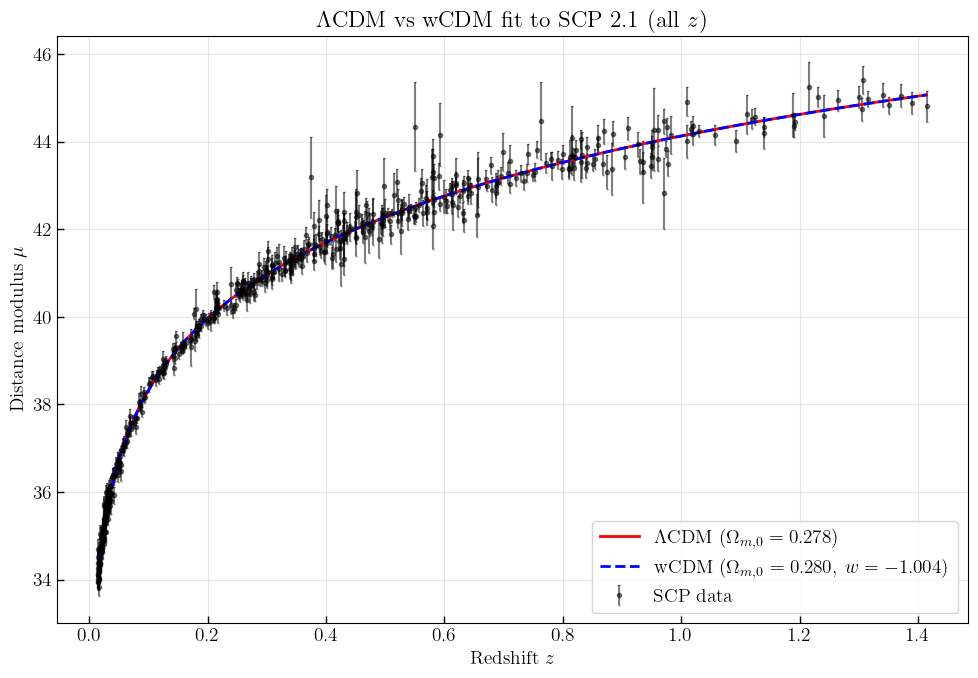

In [11]:
z_plot = z_plot_all
mu_lcdm_plot = distance_modulus_cosmo(z_plot, E_LCDM, (Omega_m0_mle_lcdm,))
mu_wcdm_plot = distance_modulus_cosmo(z_plot, E_wCDM, (Omega_m0_mle_wcdm, w_mle))

plt.figure(figsize=(10, 7))
plt.errorbar(
    z_all, mu_all, yerr=mu_err_all,
    fmt='o', ms=3, alpha=0.5, capsize=1,
    color='black', label='SCP data'
)
plt.plot(
    z_plot, mu_lcdm_plot, 'r-', lw=2,
    label=rf'$\Lambda$CDM ($\Omega_{{m,0}}={Omega_m0_mle_lcdm:.3f}$)'
)
plt.plot(
    z_plot, mu_wcdm_plot, 'b--', lw=2,
    label=rf'wCDM ($\Omega_{{m,0}}={Omega_m0_mle_wcdm:.3f}$, $w={w_mle:.3f}$)'
)
plt.xlabel('Redshift $z$')
plt.ylabel(r'Distance modulus $\mu$')
plt.title(r'$\Lambda$CDM vs wCDM fit to SCP 2.1 (all $z$)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("7.png", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
print("POSTERIOR FOR Ω_m0 IN ΛCDM")
from tqdm import tqdm

def log_posterior_lcdm(params, z, mu_obs, mu_err):
    Omega_m0 = params[0]
    if not (0.0 <= Omega_m0 <= 1.0):
        return -np.inf
    return loglike_LCDM(params, z, mu_obs, mu_err)

# MCMC setup
nwalkers = 32
ndim     = 1
nsteps   = 3000
burnin   = 1000

initial_pos = Omega_m0_mle_lcdm + 0.01 * np.random.randn(nwalkers, ndim)

sampler_lcdm = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_lcdm,
    args=(z_all, mu_all, mu_err_all)
)

print("Running MCMC for Ω_m0 (ΛCDM)...")
sampler_lcdm.run_mcmc(initial_pos, nsteps, progress=True)

Omega_m0_samples = sampler_lcdm.chain[:, burnin:, 0].reshape(-1)

Omega_m0_med  = np.median(Omega_m0_samples)
Omega_m0_low, Omega_m0_high = np.percentile(Omega_m0_samples, [16, 84])

print("Posterior for Ω_m0:")
print(f"  Median = {Omega_m0_med:.4f}")
print(f"  68% CI = [{Omega_m0_low:.4f}, {Omega_m0_high:.4f}]")



POSTERIOR FOR Ω_m0 IN ΛCDM
Running MCMC for Ω_m0 (ΛCDM)...


100%|████████████████████████████████████████████████████| 3000/3000 [31:19<00:00,  1.60it/s]

Posterior for Ω_m0:
  Median = 0.2783
  68% CI = [0.2652, 0.2917]


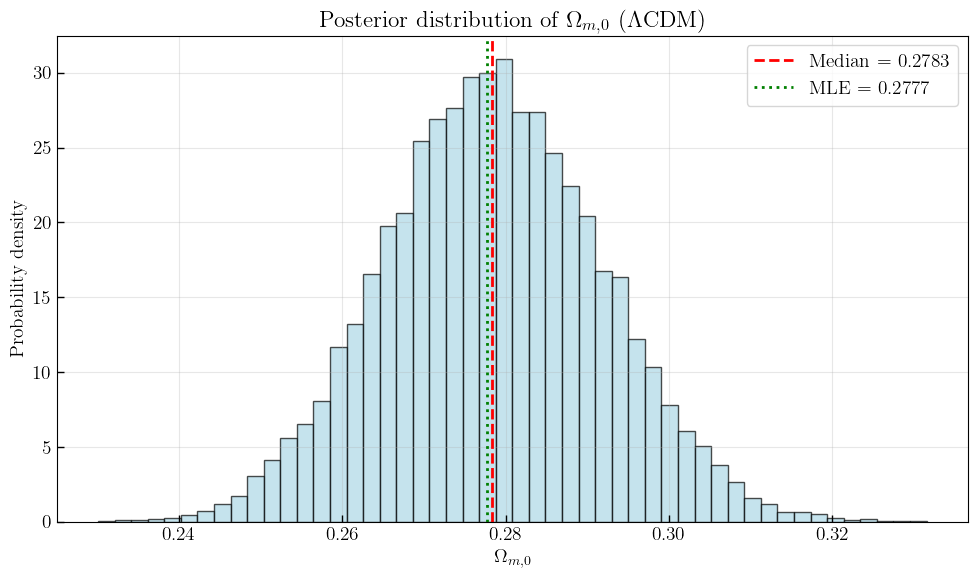

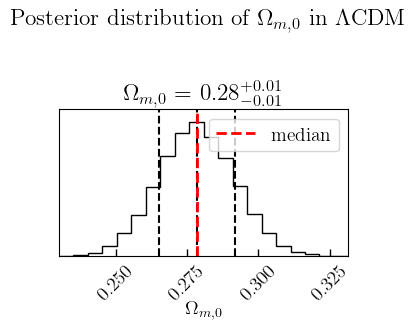

In [13]:
# Histogram + MLE
plt.figure(figsize=(10, 6))
plt.hist(Omega_m0_samples, bins=50, density=True,
         alpha=0.7, color='lightblue', edgecolor='black')
plt.axvline(Omega_m0_med, color='red', ls='--', lw=2,
            label=rf'Median = {Omega_m0_med:.4f}')
plt.axvline(Omega_m0_mle_lcdm, color='green', ls=':', lw=2,
            label=rf'MLE = {Omega_m0_mle_lcdm:.4f}')
plt.xlabel(r'$\Omega_{m,0}$')
plt.ylabel('Probability density')
plt.title(r'Posterior distribution of $\Omega_{m,0}$ ($\Lambda$CDM)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("8.png", dpi=300, bbox_inches="tight")
plt.show()

# 1D corner plot
fig = corner.corner(
    Omega_m0_samples.reshape(-1, 1),
    labels=[r'$\Omega_{m,0}$'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True
)
ax = fig.axes[0]
ax.axvline(Omega_m0_med, color='red', ls='--', lw=2, label='median')
ax.legend()
fig.suptitle('Posterior distribution of $\\Omega_{m,0}$ in $\Lambda$CDM', y=1.02)
plt.tight_layout()
plt.savefig("9.png", dpi=300, bbox_inches="tight")
plt.show()


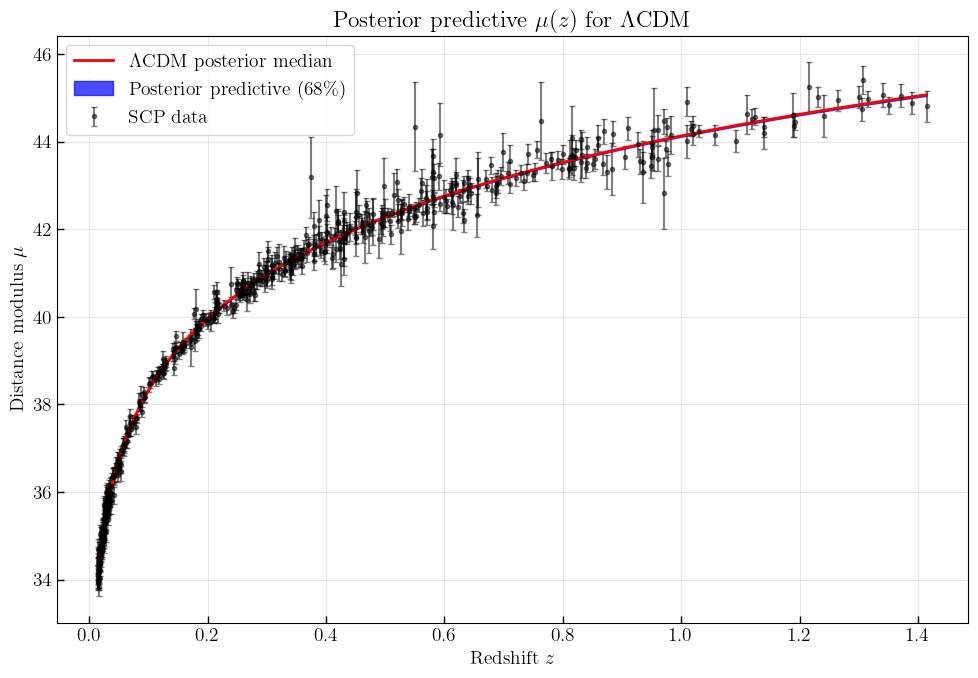

In [14]:
# Posterior predictive μ(z) for ΛCDM across all z
z_grid = z_plot_all

n_draws = 200
rng = np.random.default_rng(42)
idx = rng.choice(Omega_m0_samples.size, size=n_draws, replace=False)
Omega_draws = Omega_m0_samples[idx]

mu_pp = np.empty((n_draws, z_grid.size))
for i, Om in enumerate(Omega_draws):
    mu_mean_i = distance_modulus_cosmo(z_grid, E_LCDM, (Om,))
    mu_pp[i] = mu_mean_i  # parameter uncertainty only; add noise if desired

mu_med  = np.median(mu_pp, axis=0)
mu_low, mu_high = np.percentile(mu_pp, [16, 84], axis=0)

plt.figure(figsize=(10, 7))
plt.errorbar(
    z_all, mu_all, yerr=mu_err_all,
    fmt='o', ms=3, alpha=0.5, capsize=2,
    color='black', label='SCP data'
)
plt.plot(z_grid, mu_med, 'r-', lw=2, label='$\Lambda$CDM posterior median')
plt.fill_between(
    z_grid, mu_low, mu_high,
    color='blue', alpha=0.7, label='Posterior predictive (68\%)'
)
plt.xlabel('Redshift $z$')
plt.ylabel(r'Distance modulus $\mu$')
plt.title(r'Posterior predictive $\mu(z)$ for $\Lambda$CDM')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("my_figure_name.png", dpi=300, bbox_inches="tight")
plt.show()
